Crowdsourcing data analysis: Do soccer referees give more red cards to dark skin toned players?
=====

## Crowdstorming analytics, see: [`https://osf.io/gvm2z/`](https://osf.io/gvm2z/)

Initial data visualisation from Team 23: ([Tom Stafford](http://www.tomstafford.staff.shef.ac.uk/), Mat Evans, Colin Bannard & Tim Heaton)

Here we present the code, results and commentary of our initial exploration of the dataset. Our final analysis (lead: Tom Stafford) was conducted in R, using the packages lme4 (lead: Tim Heaton) and MCMCglmm (lead: Colin Bannard). All code for this is available on the [OSF](https://osf.io/akqt4/). This analysis was dependent on the exploration presented below (lead: [Mat Evans](http://mathewzilla.github.io/)).

Enjoy our final team report [here](https://osf.io/u5wpe/).

__The figures below were generated using matplotlib, but made pretty through the use of [seaborn](http://web.stanford.edu/~mwaskom/software/seaborn/) and [mpld3](http://mpld3.github.io/)__

# 1 Loading the data and analysis libraries

To get started, let's import some libraries

In [1]:
import pandas as pd                                     # for dealing with csv import
import numpy as np                                      # arrays and other matlab like manipulation
import os                                               # for joining paths and filenames sensibly
import matplotlib.pyplot as plt                         # Matplotlib's pyplot: MATLAB-like syntax
import scipy.stats.mstats as ssm                        # for bootstrap
from scipy.stats import gaussian_kde as kde
import random

%matplotlib inline
import seaborn as sns                                   # For pretty plots

# from mpld3 import display_d3
# mpld3.enable_notebook()                               # Interactive plots on as default
# mpld3.disable_notebook()

Now we need some data.

In [2]:
# Import original data, then do a bit of data-munging to get it in displayable form.
file_path = '/Users/sebastian/Documents/Uni/Sheffield (MSc)/2. Semester/Research Project/msc_dissertation_project'
os.chdir(file_path)

filename = os.path.join('data', 'CrowdstormingDataJuly1st.csv') 
df = pd.read_csv(filename)

By default the data is in a rather counter-intuitive format: referee-player dyads. What is a dyad..? In sociology, a dyad (from the Greek: δυάς dyás, "pair") is a group of two people, the smallest possible social group. As an adjective, "dyadic" describes their interaction.

A referee-player dyad describes the interactions between a particular ref and one player. This means that each row in the dataset is of a unique player-ref combination, listing all of the games by a given player with a particular referee at any point in his career. Let's look at the first few rows of the dataset as an example:

In [3]:
pd.set_option('display.max_columns', None)
df.head(10)

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,photoID,rater1,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,0,1,0,0,0,0,95212.jpg,0.25,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,0,1,0,1,0,0,1663.jpg,0.75,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
2,abdon-prats,Abdón Prats,RCD Mallorca,Spain,17.12.1992,181.0,79.0,NaN,1,0,1,0,0,1,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
3,pablo-mari,Pablo Marí,RCD Mallorca,Spain,31.08.1993,191.0,87.0,Center Back,1,1,0,0,0,0,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
4,ruben-pena,Rubén Peña,Real Valladolid,Spain,18.07.1991,172.0,70.0,Right Midfielder,1,1,0,0,0,0,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
5,aaron-hughes,Aaron Hughes,Fulham FC,England,08.11.1979,182.0,71.0,Center Back,1,0,0,1,0,0,0,0,3868.jpg,0.25,0.00,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752
6,aleksandar-kolarov,Aleksandar Kolarov,Manchester City,England,10.11.1985,187.0,80.0,Left Fullback,1,1,0,0,0,0,0,0,47704.jpg,0.00,0.25,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752
7,alexander-tettey,Alexander Tettey,Norwich City,England,04.04.1986,180.0,68.0,Defensive Midfielder,1,0,0,1,0,0,0,0,22356.jpg,1.00,1.00,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752
8,anders-lindegaard,Anders Lindegaard,Manchester United,England,13.04.1984,193.0,80.0,Goalkeeper,1,0,1,0,0,0,0,0,16528.jpg,0.25,0.25,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752
9,andreas-beck,Andreas Beck,1899 Hoffenheim,Germany,13.03.1987,180.0,70.0,Right Fullback,1,1,0,0,0,0,0,0,36499.jpg,0.00,0.00,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752


We already see some strange things in the data. Some refs officiated very few games. The two raters disagree about player skintone quite often. For some players there isn't a photo, so their skin tone couldn't be rated. Most dyads don't feature cards at all. In general, it's difficult to get an intuition for what the population looks like from inspecting small samples of the data. This is particularly difficult in the dyad format, as each player or ref's cards are spread un-evenly across the dataset. 

# 2 Disaggregating the data into single player-ref interactions

Team Sheffield felt a more natural format for the data was to *disaggregate* it. In other words, to unpack each dyad into singular ref-player interaction. In other words, each time a player and a referee met they would contribute one row to the dataset (and thus that interaction has a maximum of one red card). 

If you're interested in how the disaggregation was done, the [code is in our project folder on the OSF](https://osf.io/akqt4/) - the file is disaggregate_v3.py

In [4]:
# Load disaggregated data
dfd = pd.read_csv(file_path + '/data/crowdstorm_disaggregated.csv') 

We now have a much more 'normal' dataset, where each data point accounts for a single interaction (i.e. a game) . 

### What is the distribution of individual ref-player dyad game numbers? 

highest number of games in a single dyad = 47


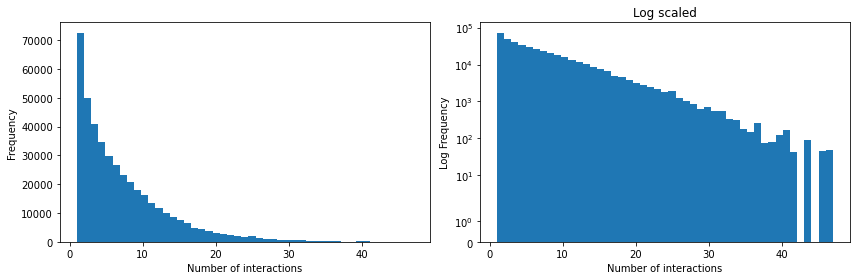

In [5]:
# Pull out the number of games in each dyad and plot 
games = dfd.games

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

axes[0].hist(games,bins=max(games),histtype = 'stepfilled')
axes[0].set_xlabel('Number of interactions')
axes[0].set_ylabel('Frequency')

axes[1].hist(games,bins=max(games),histtype = 'stepfilled')
axes[1].set_yscale('symlog') # symetric log scale NOTE this breaks the nice plotting tools
axes[1].set_title("Log scaled")
axes[1].set_xlabel('Number of interactions')
axes[1].set_ylabel('Log Frequency')


fig.tight_layout()
# display_d3()

print("highest number of games in a single dyad = " + str(max(games)))

### i.e. how likely is it that a single ref officiates the same player many times?

#### Answer: not very
Half of the dyads are unique, with the other half following an exponential decay all the way out to a high of 47 games, which is actually a pretty huge number. Who are the players featuring in these high (>=40, say) game dyads (ie the guys who meet the same ref 40+ times)?

In [7]:
stalwarts = dfd[dfd.games >= 40]
print(stalwarts.player.unique())

['Bastian Schweinsteiger' 'Philipp Lahm' 'Paul Scholes' 'Michael Carrick'
 'Wayne Rooney' 'Mark Schwarzer' 'Ashley Cole' 'Frank Lampard'
 'James Milner' 'John Terry']


Now, that at least makes sense. We see that many England Internationals, and two World Cup winning German Internationals (each with long careers in top-flight football) have played with the same referees many times.

By contrast, how rare are red cards?

In [9]:
print("Total interactions =", len(dfd))
clean_interactions = dfd[(dfd['allreds'] == 0)]
print("Number of red cards in the dataset =", len(dfd) - len(clean_interactions))
print("Number of interactions without a red card =", len(clean_interactions))

print("Proportion of interactions that are 'clean' =", len(clean_interactions) / float(len(dfd)))

Total interactions = 426572
Number of red cards in the dataset = 3496
Number of interactions without a red card = 423076
Proportion of interactions that are 'clean' = 0.991804431608263


In sum, red cards are very rare. We also showed that the distributions of player and ref occurance are highly skewed. Therefore, any analysis method applied to this population needs to be able to handle these properties of the data set.

# 3 Discovering a major source of data impurity 

How we worked out that players' entire histories are included in the data set

### How many refs are there in the dataset?

In [39]:
allRefs = dfd.refNum.value_counts()
print("Number of refs =", len(allRefs))
print("Number of dyads in the dataset =", sum(allRefs))

Number of refs = 3147
Number of dyads in the dataset = 426572


### Let's now look at the countries referees come from. There are a lot of them

(-3.0, 160.0)

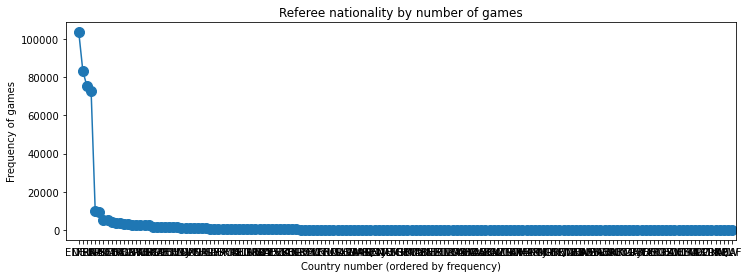

In [22]:
import mpld3
mpld3.enable_notebook()

# Histogram of country frequency. 
fig, ax = plt.subplots(1, 1, figsize = (12, 4))
x = dfd.Alpha_3.value_counts()
lines = ax.plot(x, marker = '.', ms = 20)

y = x.index.tolist() 

tooltips = mpld3.plugins.PointLabelTooltip(lines[0], labels = y)
mpld3.plugins.connect(plt.gcf(), tooltips)

ax.set_title('Referee nationality by number of games')
ax.set_xlabel('Country number (ordered by frequency)')
ax.set_ylabel('Frequency of games')
ax.set_xlim([-3, 160]) # a hack so we can see the first point most clearly

In [31]:
mpld3.disable_notebook()

### Please enjoy roll-over functionality for this plot!

Most games are ref'ed by someone from one of a small number of countries, as we would expect - the four premier leagues which defined selection for our data set: england, germany, france and spain.

However, it also seems like 160 different nationalities are represented by our referees. This seemed unlikely, are there really refs from almost every country on earth in the four premier leagues in the season 2012-13?

### And what does the distribution of ref occurance look like?

Total number of referees = 3147
Median number of dyads per referee = 11.0


Text(0, 0.5, 'log (frequency)')

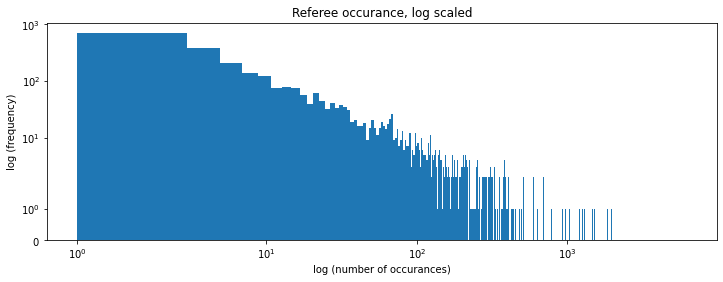

In [32]:
numRefs = len(dfd.refNum.value_counts())
print("Total number of referees =", numRefs)
print("Median number of dyads per referee =", np.median(dfd.refNum.value_counts()))

fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (12, 4))
axes.hist(dfd.refNum.value_counts().tolist(),bins = numRefs)
axes.set_xscale('symlog') # symetric log scale 
axes.set_yscale('symlog') 
axes.set_title("Referee occurance, log scaled")
axes.set_xlabel('log (number of occurances)')
axes.set_ylabel('log (frequency)')

We see that though most refs are only involved in a small number of dyads, many officiated over thousands. A median of 11 indicates that more than half of the refs officiated less than one game!

Something funny is going on - If a ref officiated a full game in one of our selected premier leagues they would be in at *least* 22 dyads (2 teams of 11 players each, more if substitutions occur).

Futher analysis (not shown), including a bit of eyeballing, revealled that players' entire career histories are included in the dataset. This means that if a player gets sent off in a Uruguayan league game in 2002, but then transfers to the English premier league by 2012 then this booking ends up in our dataset - as does the referee. This explains the high number of ref nationalities present in the data set

### We clean the data by excluding interactions by refs who feature in fewer than 22 dyads

If you aren't in at least 22 dyads you didn't ref a game in one of our four defining leagues

In [41]:
goodRefs = allRefs[allRefs > 21]

Text(0, 0.5, 'log (frequency)')

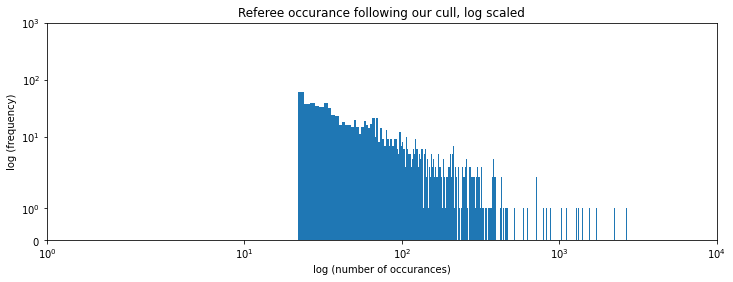

In [42]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (12, 4))
axes.hist(goodRefs.tolist(),numRefs-11)
axes.set_xscale('symlog') # symetric log scale 
plt.xlim([1,10000])
axes.set_yscale('symlog') 
plt.ylim([0,1000])
axes.set_title("Referee occurance following our cull, log scaled")
axes.set_xlabel('log (number of occurances)')
axes.set_ylabel('log (frequency)')

In [43]:
print("Number of refs featuring in at least 22 dyads =",len(goodRefs))
print("Number of dyads, excluding refs who officiate fewer than 22 games =", sum(goodRefs))

Number of refs featuring in at least 22 dyads = 1261
Number of dyads, excluding refs who officiate fewer than 22 games = 415692


We lose approx 2/3rds of refs, but keep 97.4% of dyads

In [44]:
# Copying from 
# http://stackoverflow.com/questions/12065885/how-to-filter-the-dataframe-rows-of-pandas-by-within-in

# This line defines a new dataframe based on our >21 games filter
dfd_good = dfd[dfd['refNum'].isin(goodRefs.index.values)]

# pandas is like being in a alien spaceship - you know you potentially control unimaginable power,
# but don't know what any of the buttongs actually do

(-3.0, 160.0)

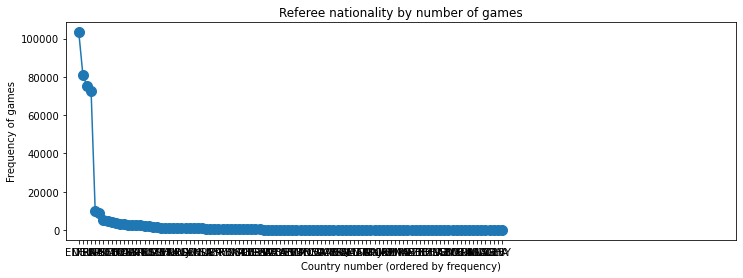

In [45]:
import mpld3
mpld3.enable_notebook()
# Histogram of country frequency. 
fig, ax = plt.subplots(1, 1, figsize = (12, 4))
x = dfd_good.Alpha_3.value_counts()
lines = ax.plot(x, marker = '.', ms = 20)

y = x.index.tolist() 

tooltips = mpld3.plugins.PointLabelTooltip(lines[0], labels = y)
mpld3.plugins.connect(plt.gcf(), tooltips)

ax.set_title('Referee nationality by number of games')
ax.set_xlabel('Country number (ordered by frequency)')
ax.set_ylabel('Frequency of games')
ax.set_xlim([-3, 160]) # a hack so we can see the first point most clearly

In [46]:
mpld3.disable_notebook()

Still 100+ nationalities represented

# 4 Skintone ratings could be better

We noted that ratings of skintone could be more reliable. The ratings are fairly different at the light end of the spectrum. The two raters disagree on 28742 or 19% of the time, and looking at the histograms of their responses most of these are between the first two categories. These first two categories account for ~ 70% of both rater's classifications, so biases/inconsistencies/uncertainty in this part of the dataset could have a large effect on the rest of the analysis. There could be many reasons for this, but one obvious way of dealing with it would be to use N > 2 raters. 

Mean skintone across the population = 0.27960527197527524


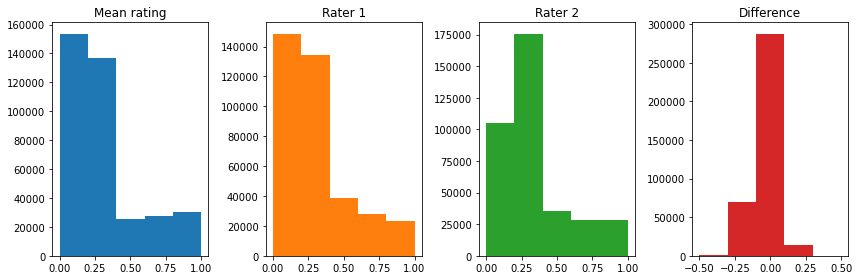

In [35]:
# Plot of skin tone rating distributions, showing skewed nature of the data w/ histograms 
# and degree of disagreement between raters with a scatterplot
rated = ((dfd['rater1'] + dfd['rater2']) / 2).dropna()

fig, ax = plt.subplots(1, 4, figsize = (12, 4))
c = sns.color_palette()
ax[0].hist(rated, bins = 5, range = (0,1), color = c[0])
ax[0].set_title("Mean rating")

ax[1].hist(dfd['rater1'].dropna().tolist(),bins = 5, range = (0, 1), color = c[1])
ax[1].set_title('Rater 1')

ax[2].hist(dfd['rater2'].dropna().tolist(),bins = 5, range = (0, 1), color = c[2])
ax[2].set_title('Rater 2')

ax[3].hist((dfd['rater1'] - dfd['rater2']).dropna(), bins = 5,range = (-0.5, 0.5), color = c[3])
ax[3].set_title('Difference')


fig.tight_layout()

print('Mean skintone across the population =', np.mean(rated))

### Scatter plot of skintone ratings. Jitter added for visualisation

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


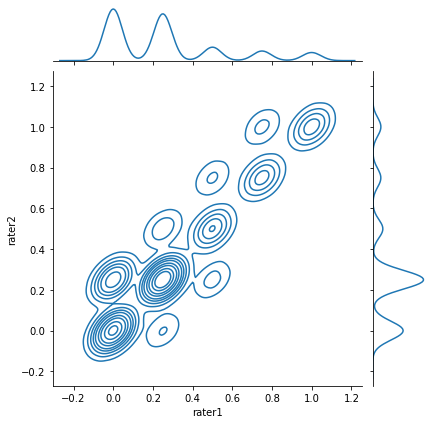

In [36]:
c = sns.color_palette()
jitter_x = np.random.normal(0, 0.04, size = len(dfd.rater1))
jitter_y = np.random.normal(0, 0.04, size = len(dfd.rater2))
sns.jointplot(dfd.rater1 + jitter_x, dfd.rater2 + jitter_y, kind = 'kde')

# 5 Let's look at the implicit and explicit racism scores, and their sample size distributions

Most of the refs come from 4 countries (where the 4 represented leagues are). It's a shame there is no data from Italy but never mind. It's hard to know how reliable the IAT and Exp scores are with respect to the other countries, esp if there is some variation between ref biases within a country. The IAT and Exp scores might not have as much variation as within country variation..

There doesn't seem to be much 'signal' here. Also the sample sizes, though large, are then undermined by the small sample sizes for refs in some countries (data not shown, but see above)

Text(0.5, 1.0, 'Mean Exp - culled')

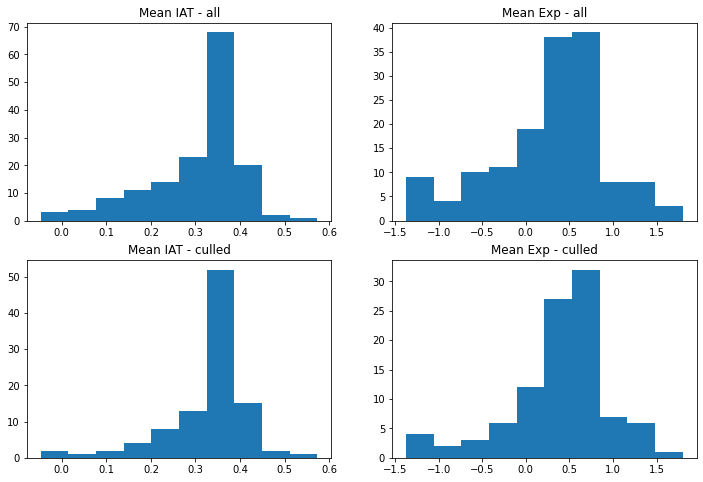

In [47]:
# Linked subplots showing these distributions, or a scatter plot with variable dot sizes showing how much overlap there is.
fig, ax = plt.subplots(2, 2, figsize = (12, 8))
ax[0, 0].hist(dfd.meanIAT.dropna().unique())
ax[0, 0].set_title("Mean IAT - all")
ax[0, 1].hist(dfd['meanExp'].dropna().unique())
ax[0, 1].set_title("Mean Exp - all")

ax[1, 0].hist(dfd_good.meanIAT.dropna().unique())
ax[1, 0].set_title("Mean IAT - culled")
ax[1, 1].hist(dfd_good['meanExp'].dropna().unique())
ax[1, 1].set_title("Mean Exp - culled")

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


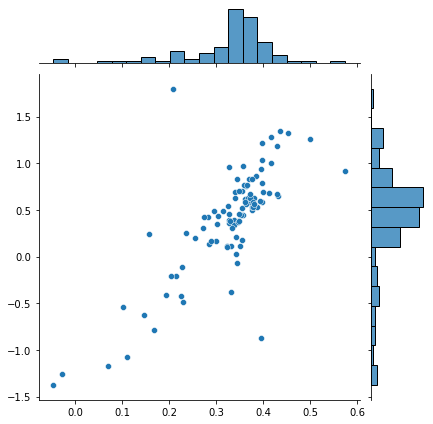

In [48]:
sns.jointplot(dfd_good['meanIAT'].dropna().unique(),dfd_good['meanExp'].dropna().unique())

implicit (IAT) and explicit (EXP) attitude correlate highly

Text(0.5, 1.0, 'Most IAT scores are based on samples of < 1000')

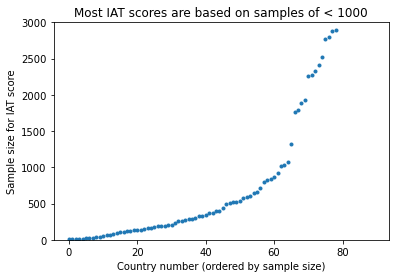

In [49]:
x = dfd_good.nIAT.dropna().unique()
plt.plot(np.sort(x), '.')


plt.xlabel('Country number (ordered by sample size)')
plt.ylabel('Sample size for IAT score')

plt.ylim([0, 3000])
plt.title('Most IAT scores are based on samples of < 1000')

So perhaps not too surprising that the country attitude scores (both explicit and implicit) don't predict carding by individual referrees

# 6 Concluding thoughts

At least half of the analysis effort was the initial data exploration and visualisation. Normally this is not shown directly in the reporting of a scientific project. We felt, particularly for this project, that it was worth bringing to light some of this work.

The ipython notebook allows code, commentary and results to be combined (and, if you run it in interactive mode, to be actively developed between several people)

There is a trend in behavioural science to very large datasets. When these are incidentally collected (e.g. data provided by companies or beaurocracies), or when they are collected via highly complex/opaque techniques (e.g. many kinds of imaging data) we, as scientists, are often ignorant of the exact form the data take, and the attendant peculiarities and nuances. This means that every analysis project is more and more a visualisation project as well.


Mat Evans [@mathewe](twitter.com/mathewe)

Tom Stafford [@tomstafford](http://twitter.com/tomstafford)

Nov 2014